In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import get_blas_funcs
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

class Semi_EM_MultinomialNB():
    """
    Naive Bayes classifier for multinomial models for semi-supervised learning.
    
    Use both labeled and unlabeled data to train NB classifier, update parameters
    using unlabeled data, and all data to evaluate performance of classifier. Optimize
    classifier using Expectation-Maximization algorithm.
    """
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None, max_iter=30, tol=1e-6, print_log_lkh=True):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        self.clf = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior, class_prior=self.class_prior)
        self.log_lkh = -np.inf # log likelihood
        self.max_iter = max_iter # max number of EM iterations
        self.tol = tol # tolerance of log likelihood increment
        self.feature_log_prob_ = np.array([]) # Empirical log probability of features given a class, P(x_i|y).
        self.coef_ = np.array([]) # Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.
        self.print_log_lkh = print_log_lkh # if True, print log likelihood during EM iterations

    def fit(self, X_l, y_l, X_u):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def fit_with_clustering(self, X_l, y_l, X_u, y_u=None):
        """
        Initialize the parameter using both labeled and unlabeled data.
        The classes of unlabeled data are assigned using similarity with labeled data.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        The label propagation can only use dense matrix, so it is quite time consuming.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs): 
        # assign class to unlabeled data using similarity with labeled data if y_u is not given
        if (y_u==None):
            label_prop_model = LabelSpreading(kernel='rbf', max_iter=5, n_jobs=-1)
            y_u = np.array([-1.0]*n_ul_docs)
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            label_prop_model.fit(X.toarray(), y)
            y_u = label_prop_model.predict(X_u.toarray())
        y = np.concatenate((y_l, y_u), axis=0)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X, y) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def partial_fit(self, X_l, y_l, X_u=np.array([])):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        This function can only be used after fit()
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.partial_fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.partial_fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        return self.clf.score(X, y)

    def get_params(deep=True):
        return self.clf.get_params(deep)

    def __str__(self):
        return self.clf.__str__()

In [3]:
# Import packages and libraries
import numpy as np
import random as rnd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
#from Semi_EM_NB import Semi_EM_MultinomialNB
from os import path
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
def remove_noise(sentence):
    result = ''
    poster = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stopword_set = set(stopwords.words('english'))
    wordlist = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', sentence) # remove punctuation
    wordlist = re.sub('\s+', ' ', wordlist) # remove extra space
    wordlist_normal = [poster.stem(word.lower()) for word in wordlist.split()] # restore word to its original form (stemming)
    wordlist_normal = [lemmatizer.lemmatize(word, pos='v') for word in wordlist_normal] # restore word to its root form (lemmatization)
    wordlist_clean = [word for word in wordlist_normal if word not in stopword_set] # remove stopwords
    result = ' '.join(wordlist_clean)
    return result

In [5]:
def cross_validation(clf, data_X, data_y, unlabeled=None, n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==None:
            cv_clf.fit(train_X, train_y)
        else:
            cv_clf.fit(train_X, train_y, unlabeled)
        pred = cv_clf.predict(valid_X)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    return train_scores, train_time

In [6]:
def show_topK(classifier, vectorizer, categories, K=10):
    feature_names = np.asarray(vectorizer.get_feature_names())
    nrows, ncols = 5, 4
    fig, axes = plt.subplots(figsize=(50, 40), nrows=nrows, ncols=ncols)
    #d = path.dirname(__file__)
    circle_mask = np.array(Image.open(path.join('./', "circle.png")))
    for i, category in enumerate(categories):
        topK = np.argsort(classifier.coef_[i])[-K:]
        text = " ".join(feature_names[topK])
        print("%s: %s" % (category, text))
        wordcloud = WordCloud(background_color="white", mask=circle_mask).generate(text)
        axes[i//ncols, i%ncols].imshow(wordcloud, cmap=plt.cm.cool_r, interpolation='bilinear')
        axes[i//ncols, i%ncols].axis("off")
        axes[i//ncols, i%ncols].set_title(category, fontweight="bold", size=24)
    plt.show()

In [7]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


In [8]:
# preprocess train and test text data
train_X_clean = map(remove_noise, train_X)
test_X_clean = map(remove_noise, test_X)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.95)
# vectorizer = TfidfVectorizer()
train_vec = vectorizer.fit_transform(train_X_clean)
test_vec = vectorizer.transform(test_X_clean)
print (train_vec.shape, test_vec.shape)

(15076, 13237) (3770, 13237)


In [10]:
# Divide train data set into labeled and unlabeled data sets
split_ratio = 0.2 # labeled vs total(labeled+unlabeled)
# X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, train_size=split_ratio, stratify=train_y)
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=20, base=10, dtype='int')
print (X_l.shape, X_u.shape)

(5076, 13237) (10000, 13237)


In [11]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs])
    nb_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.084 seconds
Average training accuracy: 0.438
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.062 seconds
Average training accuracy: 0.458
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.059 seconds
Average training accuracy: 0.457
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.060 seconds
Average training accuracy: 0.480
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.060 seconds
Average training accuracy: 0.496
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold 

In [12]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time = cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 96.508 seconds
Average training accuracy: 0.498
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 69.696 seconds
Average training accuracy: 0.559
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 68.121 seconds
Average training accuracy: 0.532
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 63.969 seconds
Average training accuracy: 0.532
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 61.640 seconds
Average training accuracy: 0.552
Number of labeled documents:    393
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4


Text(0.5, 1.0, 'Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

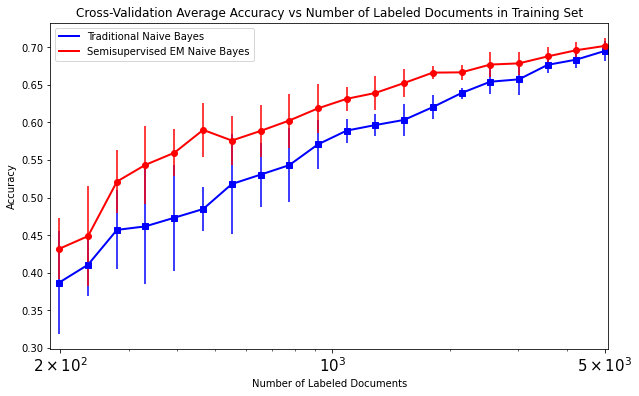

In [ ]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents in Training Set')

Text(0.5, 1.0, 'Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

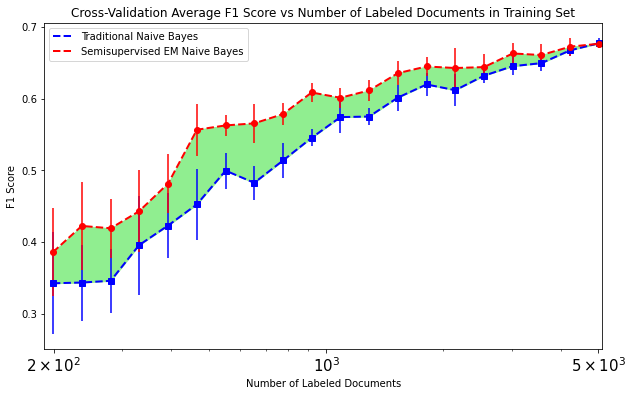

In [13]:
# plot CV F1 Score comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['f1_score'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['f1_score'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, em_nb_score_mean, color='r', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average F1 Score vs Number of Labeled Documents in Training Set')

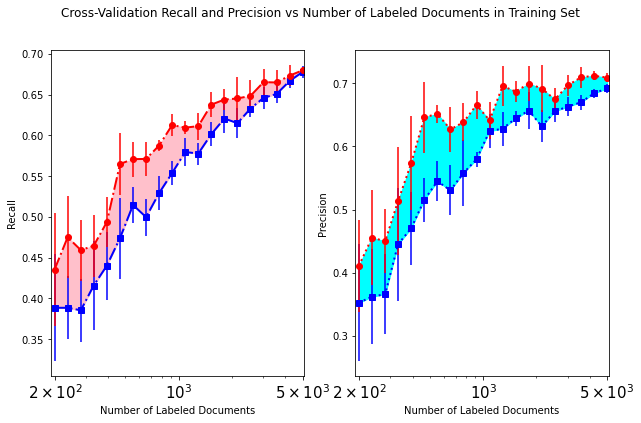

In [14]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['recall'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['recall'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_score_mean, color='b', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax1.plot(experiments, em_nb_score_mean, color='r', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax1.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['precision'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    em_nb_scores = [value['precision'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_score_mean, color='b', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax2.plot(experiments, em_nb_score_mean, color='r', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')
ax2.fill_between(experiments, nb_score_mean, em_nb_score_mean, color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Cross-Validation Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

In [15]:
# Evaluate original NB classifier using test data set
nb_test_scores = dict()
nb_test_scores['accuracy'] = list()
nb_test_scores['recall'] = list()
nb_test_scores['precision'] = list()
nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2).fit(X_l[:n_l_docs,], y_l[:n_l_docs])
    pred = nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    nb_test_scores['accuracy'].append(accuracy)
    nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.384
   236 labeled documents lead to accuracy of 0.407
   280 labeled documents lead to accuracy of 0.421
   331 labeled documents lead to accuracy of 0.431
   393 labeled documents lead to accuracy of 0.460
   466 labeled documents lead to accuracy of 0.504
   552 labeled documents lead to accuracy of 0.521
   654 labeled documents lead to accuracy of 0.549
   775 labeled documents lead to accuracy of 0.567
   918 labeled documents lead to accuracy of 0.588
  1088 labeled documents lead to accuracy of 0.612
  1289 labeled documents lead to accuracy of 0.618
  1528 labeled documents lead to accuracy of 0.631
  1810 labeled documents lead to accuracy of 0.644
  2145 labeled documents lead to accuracy of 0.652
  2542 labeled documents lead to accuracy of 0.665
  3012 labeled documents lead to accuracy of 0.672
  3569 labeled documents lead to accuracy of 0.680
  4229 labeled documents lead to accuracy of 0.696
  5011 labeled documents lead t

In [16]:
# Evaluate semi-supervised EM NB classifier using test data set
em_nb_test_scores = dict()
em_nb_test_scores['accuracy'] = list()
em_nb_test_scores['recall'] = list()
em_nb_test_scores['precision'] = list()
em_nb_test_scores['f1_score'] = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False).fit(X_l[:n_l_docs,], y_l[:n_l_docs], X_u)
    pred = em_nb_clf.predict(test_vec)
    accuracy = metrics.accuracy_score(test_y, pred)
    em_nb_test_scores['accuracy'].append(accuracy)
    em_nb_test_scores['recall'].append(metrics.recall_score(test_y, pred, average='macro'))
    em_nb_test_scores['precision'].append(metrics.precision_score(test_y, pred, average='macro'))
    em_nb_test_scores['f1_score'].append(metrics.f1_score(test_y, pred, average='macro'))
    print("%6d labeled documents lead to accuracy of %.3f" % (n_l_docs, accuracy))

   199 labeled documents lead to accuracy of 0.454
   236 labeled documents lead to accuracy of 0.480
   280 labeled documents lead to accuracy of 0.483
   331 labeled documents lead to accuracy of 0.501
   393 labeled documents lead to accuracy of 0.525
   466 labeled documents lead to accuracy of 0.588
   552 labeled documents lead to accuracy of 0.615
   654 labeled documents lead to accuracy of 0.622
   775 labeled documents lead to accuracy of 0.640
   918 labeled documents lead to accuracy of 0.646
  1088 labeled documents lead to accuracy of 0.653
  1289 labeled documents lead to accuracy of 0.656
  1528 labeled documents lead to accuracy of 0.670
  1810 labeled documents lead to accuracy of 0.666
  2145 labeled documents lead to accuracy of 0.679
  2542 labeled documents lead to accuracy of 0.685
  3012 labeled documents lead to accuracy of 0.682
  3569 labeled documents lead to accuracy of 0.697
  4229 labeled documents lead to accuracy of 0.698
  5011 labeled documents lead t

Text(0.5, 1.0, 'Test Accuracy vs Number of Labeled Documents in Training Set')

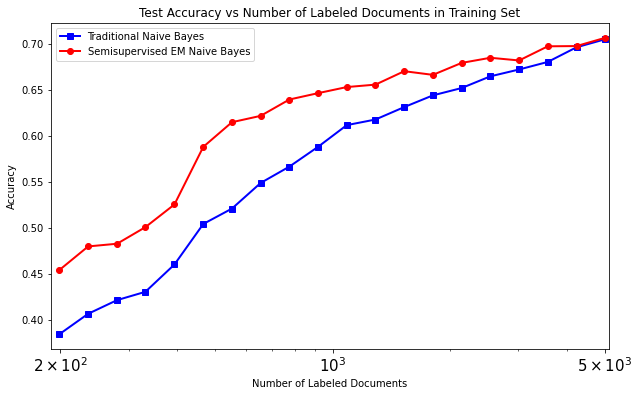

In [17]:
# Plot and compare test accuracy metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['accuracy'], color='b', marker='s', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['accuracy'], color='r', marker='o', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test Accuracy vs Number of Labeled Documents in Training Set')

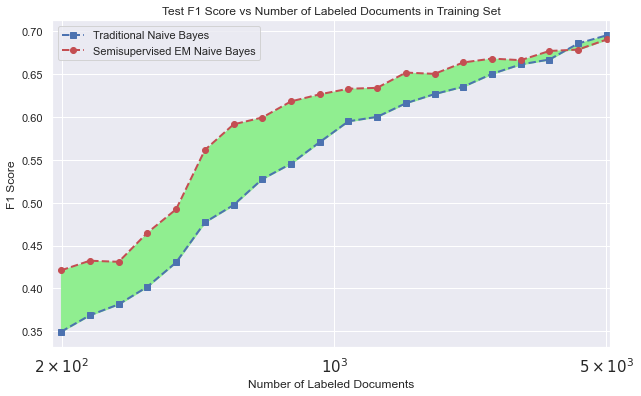

In [23]:
# Plot and compare test f1 score metrics
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_test_scores['f1_score'], color='b', marker='s', linestyle='--', linewidth=2, label='Traditional Naive Bayes')
ax.plot(experiments, em_nb_test_scores['f1_score'], color='r', marker='o', linestyle='--', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.fill_between(experiments, nb_test_scores['f1_score'], em_nb_test_scores['f1_score'], color='lightgreen')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('F1 Score')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Test F1 Score vs Number of Labeled Documents in Training Set')
plt.savefig('BOWNB5.png')

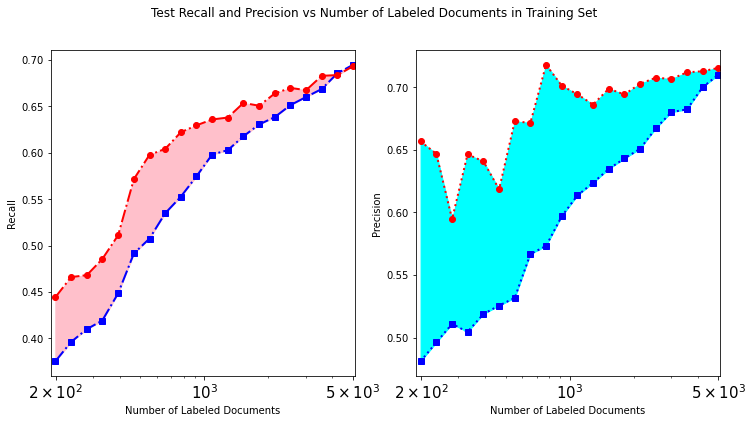

In [19]:
# Plot and compare test recall and precisions metrics
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(experiments, nb_test_scores['recall'], color='b', marker='s', linestyle='-.', linewidth=2, label='Traditional Naive Bayes')
ax1.plot(experiments, em_nb_test_scores['recall'], color='r', marker='o', linestyle='-.', linewidth=2, label='Semisupervised EM Naive Bayes')
ax1.fill_between(experiments, nb_test_scores['recall'], em_nb_test_scores['recall'], color='pink')
ax1.set_xlabel('Number of Labeled Documents')
ax1.set_ylabel('Recall')
ax1.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax1.set_xscale('log')
ax1.set_xticks([200, 1000, 5000]) 
ax1.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)

ax2 = fig.add_subplot(122)
ax2.plot(experiments, nb_test_scores['precision'], color='b', marker='s', linestyle=':', linewidth=2, label='Traditional Naive Bayes')
ax2.plot(experiments, em_nb_test_scores['precision'], color='r', marker='o', linestyle=':', linewidth=2, label='Semisupervised EM Naive Bayes')
ax2.fill_between(experiments, nb_test_scores['precision'], em_nb_test_scores['precision'], color='aqua')
ax2.set_xlabel('Number of Labeled Documents')
ax2.set_ylabel('Precision')
ax2.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax2.set_xscale('log')
ax2.set_xticks([200, 1000, 5000]) 
ax2.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
fig.suptitle('Test Recall and Precision vs Number of Labeled Documents in Training Set')
plt.show()

In [20]:
# details of classification accuracy metrics
print(metrics.classification_report(test_y, pred, target_names=category_names))

                          precision    recall  f1-score   support

             alt.atheism       0.64      0.56      0.60       160
           comp.graphics       0.66      0.68      0.67       195
 comp.os.ms-windows.misc       0.71      0.60      0.65       197
comp.sys.ibm.pc.hardware       0.61      0.70      0.65       196
   comp.sys.mac.hardware       0.73      0.65      0.69       193
          comp.windows.x       0.73      0.79      0.76       198
            misc.forsale       0.80      0.61      0.69       195
               rec.autos       0.74      0.69      0.72       198
         rec.motorcycles       0.72      0.72      0.72       199
      rec.sport.baseball       0.89      0.79      0.84       199
        rec.sport.hockey       0.91      0.89      0.90       200
               sci.crypt       0.50      0.81      0.62       198
         sci.electronics       0.70      0.64      0.67       197
                 sci.med       0.88      0.81      0.84       198
         

Text(0.5, 1.0, 'Confusion Matrix')

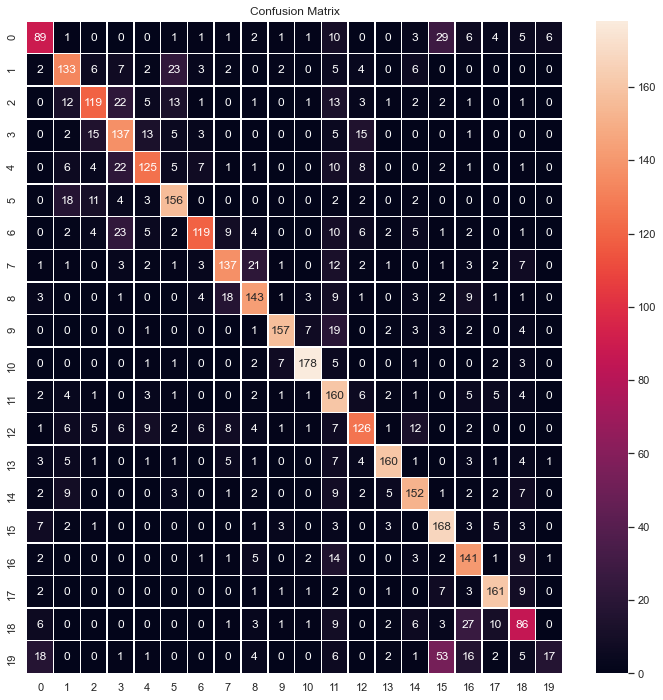

In [21]:
# plot confusion matrix for test dataset
plt.figure(figsize=(12,12))
sns.set()
sns.heatmap(metrics.confusion_matrix(test_y, pred), annot=True, fmt="d", linewidths=.5)
plt.title("Confusion Matrix")